In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
import nltk
import networkx as nx
import sys
import matplotlib.pyplot as plt
import pickle

In [2]:
# Download NLTK stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/alesac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load data

In [3]:
ts_data = pd.read_csv('data/taylor_swift_discography_updated.csv', sep=';', index_col = 'ID')
ts_data.head()

,track_name,track_musical_genre,track_type,duration_ms,feature,track_videoclip,videoclip_views,spotify_streams,spotify_global_peak,album,...,uri,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
ID,,,,,,,,,,,,,,,,,,,,,
0,Fortnight (feat. Post Malone),Synth Pop,Single,228965,Post Malone,No,0,648525069,1,The Tortured Poets Department: The Anthology,...,spotify:track:6dODwocEuGzHAavXqTbwHv,0.5020,0.504,0.386,1.53e-05,0.0961,-10.976,0.0308,192.004,0.281
1,The Tortured Poets Department,Synth Pop,B-Side,293048,No,No,0,206954130,6,The Tortured Poets Department: The Anthology,...,spotify:track:4PdLaGZubp4lghChqp8erB,0.0483,0.604,0.428,0.0,0.1260,-8.441,0.0255,110.259,0.292
2,My Boy Only Breaks His Favorite Toys,Synth Pop,B-Side,203801,No,No,0,238016975,7,The Tortured Poets Department: The Anthology,...,spotify:track:7uGYWMwRy24dm7RUDDhUlD,0.1370,0.596,0.563,0.0,0.3020,-7.362,0.0269,97.073,0.481
3,Down Bad,R&B,B-Side,261228,No,No,0,318375377,2,The Tortured Poets Department: The Anthology,...,spotify:track:1kbEbBdEgQdQeLXCJh28pJ,0.5600,0.541,0.366,"1,00E-06",0.0946,-10.412,0.0748,159.707,0.168
4,"So Long, London",Synth Pop,B-Side,262974,No,No,0,253712712,4,The Tortured Poets Department: The Anthology,...,spotify:track:7wAkQFShJ27V8362MqevQr,0.7300,0.423,0.533,0.00264,0.0816,-11.388,0.3220,160.218,0.248


In [4]:
#print size of the dataset
rows, columns = ts_data.shape
print('Number of rows: ', rows)
print('Number of columns: ', columns)

Number of rows:  577
Number of columns:  27


In [5]:
# print name of columns
print(ts_data.columns)

Index(['track_name', 'track_musical_genre', 'track_type', 'duration_ms',
       'feature', 'track_videoclip', 'videoclip_views', 'spotify_streams',
       'spotify_global_peak', 'album', 'track_number', 'album_musical_genre',
       'album_type', 'release_date', 'album_physical_sales', 'track_lyrics',
       'track_theme', 'uri', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence'],
      dtype='object')


In [6]:
# change the type of certain columns of the dataset
ts_data['release_date'] = pd.to_datetime(ts_data['release_date'], format='%d/%m/%Y')
ts_data['spotify_streams'] = ts_data['spotify_streams'].str.replace('.', '')
ts_data['spotify_streams'] = pd.to_numeric(ts_data['spotify_streams'], errors='coerce')

### We know that there are duplicates, let's print for each song the number of times it appears

In [7]:
ts_data['track_name'].value_counts()

track_name
Sweet Nothing                           3
Karma                                   3
Labyrinth                               3
Bejeweled                               3
Maroon                                  3
                                       ..
Stay Beautiful                          1
Should've Said No                       1
Mary's Song (Oh My My My)               1
A Perfectly Good Heart                  1
Teardrops on My Guitar - Pop Version    1
Name: count, Length: 361, dtype: int64

### Merge columns with exaclty the same trackname

In [8]:
def merge_rows_with_same_name(df, key_column='track_name'):
    # Group by the key_column
    grouped = df.groupby(key_column)

    def merge_values(series):
        unique_values = series.dropna().unique()
        if len(unique_values) == 1:
            return unique_values[0]
        else:
            return list(unique_values)

    merged_df = grouped.agg({col: merge_values for col in df.columns if col != key_column}).reset_index()
    
    return merged_df

In [9]:
ts_data = merge_rows_with_same_name(ts_data)

In [10]:
print(ts_data['track_name'].value_counts())
print(ts_data.shape)

track_name
willow                                         1
"Slut!" (Taylor's Version) (From The Vault)    1
...Ready For It?                               1
22                                             1
22 (Taylor's Version)                          1
                                              ..
Anti-Hero                                      1
Babe                                           1
Babe (Taylor's Version) (From The Vault)       1
Back To December                               1
Back To December (Taylor's Version)            1
Name: count, Length: 361, dtype: int64
(361, 27)


In [11]:
# Flatten the 'album' column if it contains lists
flattened_albums = ts_data['album'].explode()  # Explodes lists into separate rows
unique_albums = flattened_albums.dropna().unique()
print(unique_albums)



["1989 (Taylor's Version) [Deluxe]" "1989 (Taylor's Version)" 'reputation'
 'reputation Stadium Tour Surprise Song Playlist' 'Red (Deluxe Edition)'
 'Red' "Red (Taylor's Version)" 'Taylor Swift' 'Lover'
 '1989 (Deluxe Edition)' '1989' 'Midnights (The Til Dawn Edition)'
 'Midnights (3am Edition)' 'Midnights' 'Speak Now (Deluxe Edition)'
 'Speak Now' "Speak Now (Taylor's Version)" 'Speak Now World Tour Live'
 'Live From Clear Channel Stripped 2008' 'Fearless Platinum Edition'
 'Fearless' "Fearless (Taylor's Version)"
 'The Tortured Poets Department: The Anthology'
 'The Tortured Poets Department'
 'folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]'
 'folklore (deluxe version)' 'folklore' 'evermore (deluxe version)'
 'evermore']


In [12]:
# Remove æive album because we don't have critics on it and some songs don't have lyrics
ts_data = ts_data[ts_data['album'] != 'Speak Now World Tour Live']


# Build the network

### Clean the lyrics

In [13]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Define the text cleaning function
def clean_text(text):
    # If the input is a list, join elements into a single string
    if isinstance(text, list):
        text = ' '.join(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    # Lemmatization (convert words to their root form)
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    
    return text


In [14]:
# Apply text cleaning
ts_data['cleaned_lyrics'] = ts_data['track_lyrics'].apply(clean_text)

# Display the cleaned data
ts_data[['track_name', 'cleaned_lyrics']].head()

,track_name,cleaned_lyrics
0,"""Slut!"" (Taylor's Version) (From The Vault)",flamingo pink sunrise boulevard clink clink yo...
1,...Ready For It?,knew killer first time saw wondered many girl ...
2,22,feel like perfect night dress like hipster mak...
3,22 (Taylor's Version),feel like perfect night dress like hipster mak...
4,A Perfectly Good Heart,would wanna break perfectly good heart would w...


### Compute similarity between songs using tf-idf score and consine similarity

In [15]:
def compute_tfidf_similarity(data, text_column, index_column):
    """
    Compute TF-IDF scores and a similarity matrix for a dataset.

    Parameters:
    - data (pd.DataFrame): The input dataset.
    - text_column (str): The column containing text data for TF-IDF computation.
    - index_column (str): The column to use as the index for similarity and TF-IDF DataFrames.

    Returns:
    - tfidf_df (pd.DataFrame): DataFrame of TF-IDF scores.
    - similarity_df (pd.DataFrame): Pairwise similarity matrix based on cosine similarity.
    """
    # Step 1: Calculate TF-IDF scores
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(data[text_column])

    # Step 2: Get feature names (words) from the TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Step 3: Convert the TF-IDF matrix to a DataFrame
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=feature_names,
        index=data[index_column]
    )

    # Step 4: Compute the similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Step 5: Convert the similarity matrix to a DataFrame
    similarity_df = pd.DataFrame(
        similarity_matrix,
        index=data[index_column],
        columns=data[index_column]
    )

    # Return both TF-IDF and similarity DataFrames
    return tfidf_df, similarity_df

In [16]:
# Compute TF-IDF and similarity matrix for the dataset
tfidf_df, similarity_df = compute_tfidf_similarity(
    data=ts_data,
    text_column='cleaned_lyrics',
    index_column='track_name'
)

# Display a sample of the TF-IDF and similarity matrices
print("TF-IDF DataFrame:")
print(tfidf_df.shape)
tfidf_df.head()

TF-IDF DataFrame:
(345, 4338)


,158,16th,17,1830s,1944,1950s,1958,2003,230,25,...,youi,youll,young,younger,youplease,youre,youth,youve,zayn,zlister
track_name,,,,,,,,,,,,,,,,,,,,,
"""Slut!"" (Taylor's Version) (From The Vault)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.066442,0.047974,0.000000,0.0,0.087853,0.0,0.0,0.0,0.0
...Ready For It?,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.070920,0.000000,0.052876,0.0,0.000000,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
22 (Taylor's Version),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
A Perfectly Good Heart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [17]:
print("Similarity Matrix:")
print(similarity_df.shape)
similarity_df.head(10)

Similarity Matrix:
(345, 345)


track_name,"""Slut!"" (Taylor's Version) (From The Vault)",...Ready For It?,22,22 (Taylor's Version),A Perfectly Good Heart,A Place in this World,Afterglow,All Too Well,All Too Well (10 Minute Version) (Taylor's Version) (From The Vault),All Too Well (Taylor's Version),...,the 1 - the long pond studio sessions,the lakes - bonus track,the lakes - the long pond studio sessions,the last great american dynasty,the last great american dynasty - the long pond studio sessions,this is me trying,this is me trying - the long pond studio sessions,tis the damn season,tolerate it,willow
track_name,,,,,,,,,,,,,,,,,,,,,
"""Slut!"" (Taylor's Version) (From The Vault)",1.000000,0.056503,0.028111,0.028111,0.023424,0.093542,0.087593,0.127527,0.129298,0.127527,...,0.074027,0.059955,0.059955,0.021047,0.021047,0.040770,0.040770,0.067320,0.068489,0.036864
...Ready For It?,0.056503,1.000000,0.064690,0.064690,0.021230,0.106004,0.058898,0.075573,0.062064,0.075573,...,0.091485,0.018745,0.018745,0.053474,0.053474,0.046021,0.046021,0.022044,0.030684,0.051183
22,0.028111,0.064690,1.000000,1.000000,0.010745,0.107123,0.104782,0.080551,0.064952,0.080551,...,0.075752,0.045816,0.045816,0.039816,0.039816,0.059153,0.059153,0.022715,0.032428,0.038336
22 (Taylor's Version),0.028111,0.064690,1.000000,1.000000,0.010745,0.107123,0.104782,0.080551,0.064952,0.080551,...,0.075752,0.045816,0.045816,0.039816,0.039816,0.059153,0.059153,0.022715,0.032428,0.038336
A Perfectly Good Heart,0.023424,0.021230,0.010745,0.010745,1.000000,0.017440,0.258904,0.032648,0.031212,0.032648,...,0.043251,0.015286,0.015286,0.015250,0.015250,0.023089,0.023089,0.037869,0.055523,0.031897
A Place in this World,0.093542,0.106004,0.107123,0.107123,0.017440,1.000000,0.126949,0.153656,0.106375,0.153656,...,0.078289,0.068141,0.068141,0.026471,0.026471,0.241345,0.241345,0.115377,0.088037,0.150818
Afterglow,0.087593,0.058898,0.104782,0.104782,0.258904,0.126949,1.000000,0.057801,0.057226,0.057801,...,0.083912,0.070845,0.070845,0.035429,0.035429,0.060381,0.060381,0.038100,0.102981,0.054304
All Too Well,0.127527,0.075573,0.080551,0.080551,0.032648,0.153656,0.057801,1.000000,0.751470,1.000000,...,0.070381,0.033344,0.033344,0.037877,0.037877,0.085983,0.085983,0.106544,0.058728,0.059082
All Too Well (10 Minute Version) (Taylor's Version) (From The Vault),0.129298,0.062064,0.064952,0.064952,0.031212,0.106375,0.057226,0.751470,1.000000,0.751470,...,0.091626,0.041443,0.041443,0.038331,0.038331,0.054225,0.054225,0.084813,0.060822,0.064960


In [18]:
similarity_threshold = 0.97

# Initialize a set to store the pairs
high_similarity_pairs = set()

# Iterate through the similarity matrix
for song1 in similarity_df.index:
    for song2 in similarity_df.columns:
        # Exclude self-similarity and check if the score exceeds the threshold
        if song1 != song2 and similarity_df.at[song1, song2] > similarity_threshold:
            # Add the pair to the set (ensuring each pair is unique)
            pair = tuple(sorted((song1, song2)))
            high_similarity_pairs.add((pair[0], pair[1], similarity_df.at[song1, song2]))

# Convert the set to a DataFrame
high_similarity_df = pd.DataFrame(high_similarity_pairs, columns=["Song1", "Song2", "Similarity"])
print(high_similarity_df.shape)
high_similarity_df.head(50)


(133, 3)


,Song1,Song2,Similarity
0,I Knew You Were Trouble,I Knew You Were Trouble.,1.0
1,Sad Beautiful Tragic,Sad Beautiful Tragic (Taylor's Version),1.0
2,Girl At Home,Girl At Home (Taylor's Version),1.0
3,You Belong With Me,You Belong With Me (Taylor's Version),1.0
4,Miss Americana & The Heartbreak Prince,mirrorball,1.0
5,august,august - the long pond studio sessions,1.0
6,Holy Ground,Holy Ground (Taylor's Version),1.0
7,Welcome To New York,Welcome To New York (Taylor's Version),1.0
8,this is me trying,this is me trying - the long pond studio sessions,1.0
9,We Are Never Ever Getting Back Together,We Are Never Ever Getting Back Together (Taylo...,1.0


In [19]:
def merge_rows(row1, row2, columns):
    """
    Merges two rows by comparing column values.
    If values differ, save as a list; otherwise, keep a single value.
    Handles cases where fields might already be lists.
    """
    merged_row = {}
    for col in columns:
        values = []
        for value in [row1[col], row2[col]]:
            if isinstance(value, list):
                values.extend(value)  # Extend if already a list
            else:
                values.append(value)  # Append single values
        
        # Ensure values are unique and check for pre-existing lists
        unique_values = pd.Series(values).dropna().unique()
        # If only one unique value exists, keep it; otherwise, store as a list
        merged_row[col] = unique_values[0] if len(unique_values) == 1 else list(unique_values)
    return merged_row

# Function to merge the dataset based on high similarity pairs
def merge_high_similarity_rows(dataset, high_similarity_df):
    # Copy the dataset to avoid modifying the original
    updated_dataset = dataset.copy()
    columns = dataset.columns.tolist()
    
    for _, (song1, song2, _) in high_similarity_df.iterrows():
        # Find the rows corresponding to the pair
        row1 = updated_dataset.loc[updated_dataset['track_name'] == song1]
        row2 = updated_dataset.loc[updated_dataset['track_name'] == song2]
        
        if not row1.empty and not row2.empty:
            row1 = row1.iloc[0]
            row2 = row2.iloc[0]
            
            # Determine the shortest track name
            shortest_name = song1 if len(song1) <= len(song2) else song2
            
            # Merge the two rows
            merged_row = merge_rows(row1, row2, columns)
            merged_row['track_name'] = shortest_name  # Set the shortest name as the track name
            
            # Remove the original rows
            updated_dataset = updated_dataset[~updated_dataset['track_name'].isin([song1, song2])]
            
            # Add the merged row
            updated_dataset = pd.concat([updated_dataset, pd.DataFrame([merged_row])], ignore_index=True)
    
    return updated_dataset

# Apply the merging function to the dataset
updated_ts_data = merge_high_similarity_rows(ts_data, high_similarity_df)



In [20]:
updated_ts_data

,track_name,track_musical_genre,track_type,duration_ms,feature,track_videoclip,videoclip_views,spotify_streams,spotify_global_peak,album,...,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,cleaned_lyrics
0,"""Slut!"" (Taylor's Version) (From The Vault)",Synth Pop,Single,180381,No,No,0,239579759,2,"[1989 (Taylor's Version) [Deluxe], 1989 (Taylo...",...,"[0.309, 0.345]","[0.591, 0.629]","[0.412, 0.413]","[0.000199, 7.62e-05]","[0.0608, 0.0603]","[-13.27, -13.178]","[0.0863, 0.055]","[155.875, 77.983]","[0.328, 0.306]",flamingo pink sunrise boulevard clink clink yo...
1,...Ready For It?,Electropop,Single,208186,No,Yes,350.707.005,695895392,3,reputation,...,0.0527,0.613,0.764,0.0,0.197,-6.509,0.136,160.015,0.417,knew killer first time saw wondered many girl ...
2,A Perfectly Good Heart,Country Pop,B-Side,220146,No,No,0,25204096,0,Taylor Swift,...,0.00349,0.483,0.751,0.0,0.128,-5.726,0.0365,156.092,0.268,would wanna break perfectly good heart would w...
3,A Place in this World,Country Pop,B-Side,"[202080, 199200]",No,No,0,40680546,0,[reputation Stadium Tour Surprise Song Playlis...,...,"[0.0577, 0.051]","[0.573, 0.576]","[0.767, 0.777]",0.0,"[0.327, 0.32]","[-2.929, -2.881]","[0.0323, 0.0324]","[114.984, 115.028]","[0.438, 0.428]",dont know want dont ask cause im still trying ...
4,Afterglow,Pop,B-Side,223293,No,No,0,368409481,38,Lover,...,0.13,0.756,0.449,0.0,0.114,-8.746,0.0344,111.011,0.399,blew thing proportion youre blue put jail some...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,The Way I Loved You,Country Pop,B-Side,"[244240, 244226, 243136]",No,No,0,"[69526656, 397666679]","[0, 29]","[Fearless Platinum Edition, Fearless, Fearless...",...,"[0.0322, 0.0408, 0.0033]","[0.436, 0.433, 0.402]","[0.712, 0.7, 0.732]",0.0,"[0.111, 0.115, 0.108]","[-3.689, -3.709, -4.665]","[0.0329, 0.0336, 0.0484]","[160.886, 160.927, 161.032]","[0.379, 0.398, 0.472]",sensible incredible single friend jealous say ...
231,Jump Then Fall,Country Pop,"[B-Side, Special Deluxe]","[238093, 237066, 237580]",No,No,0,"[25320079, 54359548]","[0, 72]",[reputation Stadium Tour Surprise Song Playlis...,...,"[0.113, 0.111, 0.0474]","[0.617, 0.618, 0.572]","[0.699, 0.687, 0.69]",0.0,"[0.074, 0.0693, 0.0897]","[-5.712, -5.737, -6.201]","[0.0274, 0.0271, 0.0358]","[80.007, 79.991, 160.111]","[0.818, 0.82, 0.624]",like way sound mornin phone without warnin rea...
232,peace,Indie Folk,"[B-Side, Live]","[234000, 214373]",No,No,0,"[202357820, 10237759]","[20, 0]",[folklore: the long pond studio sessions (from...,...,"[0.916, 0.918, 0.93]","[0.644, 0.647, 0.619]","[0.284, 0.272, 0.344]","[1.5e-05, 1.73e-05, 7.61e-05]","[0.0909, 0.0918, 0.0734]","[-12.879, -12.906, -11.472]","[0.0821, 0.0916, 0.0647]","[150.072, 150.044, 149.897]","[0.328, 0.339, 0.513]",comingofage come gone suddenly summer clear ne...
233,Sparks Fly,Country Pop,"[Single, B-Side]","[262920, 260933, 261230]",No,"[No, Yes]","[0, 97.248.044]","[180160266, 111149636]","[0, 4]",[reputation Stadium Tour Surprise Song Playlis...,...,"[0.041, 0.0396, 0.0251]","[0.61, 0.605, 0.588]","[0.782, 0.787, 0.758]","[0.0, 1.42e-06]","[0.16, 0.163, 0.131]","[-2.98, -3.002, -2.347]","[0.0309, 0.0308, 0.0305]","[114.977, 114.987, 114.991]","[0.399, 0.374, 0.387]",way move like full rainstorm im house card you...


In [21]:
# Compute TF-IDF and similarity matrix for the dataset
tfidf_df, similarity_df = compute_tfidf_similarity(
    data=updated_ts_data,
    text_column='cleaned_lyrics',
    index_column='track_name'
)

### Extract top 10 words per song 

In [22]:
def extract_top_words(tfidf_df, top_n=10):
    """
    Extracts the top N highest-scoring words for each song from the TF-IDF DataFrame.

    Parameters:
        tfidf_df (DataFrame): The TF-IDF DataFrame with songs as rows and words as columns.
        top_n (int): The number of top words to extract for each song.

    Returns:
        DataFrame: A DataFrame with 'track_name' and 'top_words' columns.
    """
    top_words = []

    # Iterate over each song in the TF-IDF DataFrame
    for track_name, row in tfidf_df.iterrows():
        # Get the top N words with the highest TF-IDF scores
        top_word_indices = row.nlargest(top_n).index
        top_word_scores = row.nlargest(top_n).values
        words_with_scores = [(word, score) for word, score in zip(top_word_indices, top_word_scores)]
        
        # Append the song and its top words to the list
        top_words.append({
            'track_name': track_name,
            'top_words': words_with_scores
        })

    # Convert the list to a DataFrame
    top_words_df = pd.DataFrame(top_words)
    return top_words_df

# Extract top 10 words for each song
top_words_df = extract_top_words(tfidf_df, top_n=20)

# Display the resulting DataFrame
top_words_df.head()


,track_name,top_words
0,"""Slut!"" (Taylor's Version) (From The Vault)","[(might, 0.3552286289899761), (slut, 0.3038835..."
1,...Ready For It?,"[(begin, 0.541770582657918), (game, 0.38705435..."
2,A Perfectly Good Heart,"[(would, 0.5199760675365875), (wanna, 0.482692..."
3,A Place in this World,"[(oh, 0.38872118266290634), (im, 0.38177370057..."
4,Afterglow,"[(wanna, 0.41964103799986313), (dont, 0.333848..."


1733340 1993770030


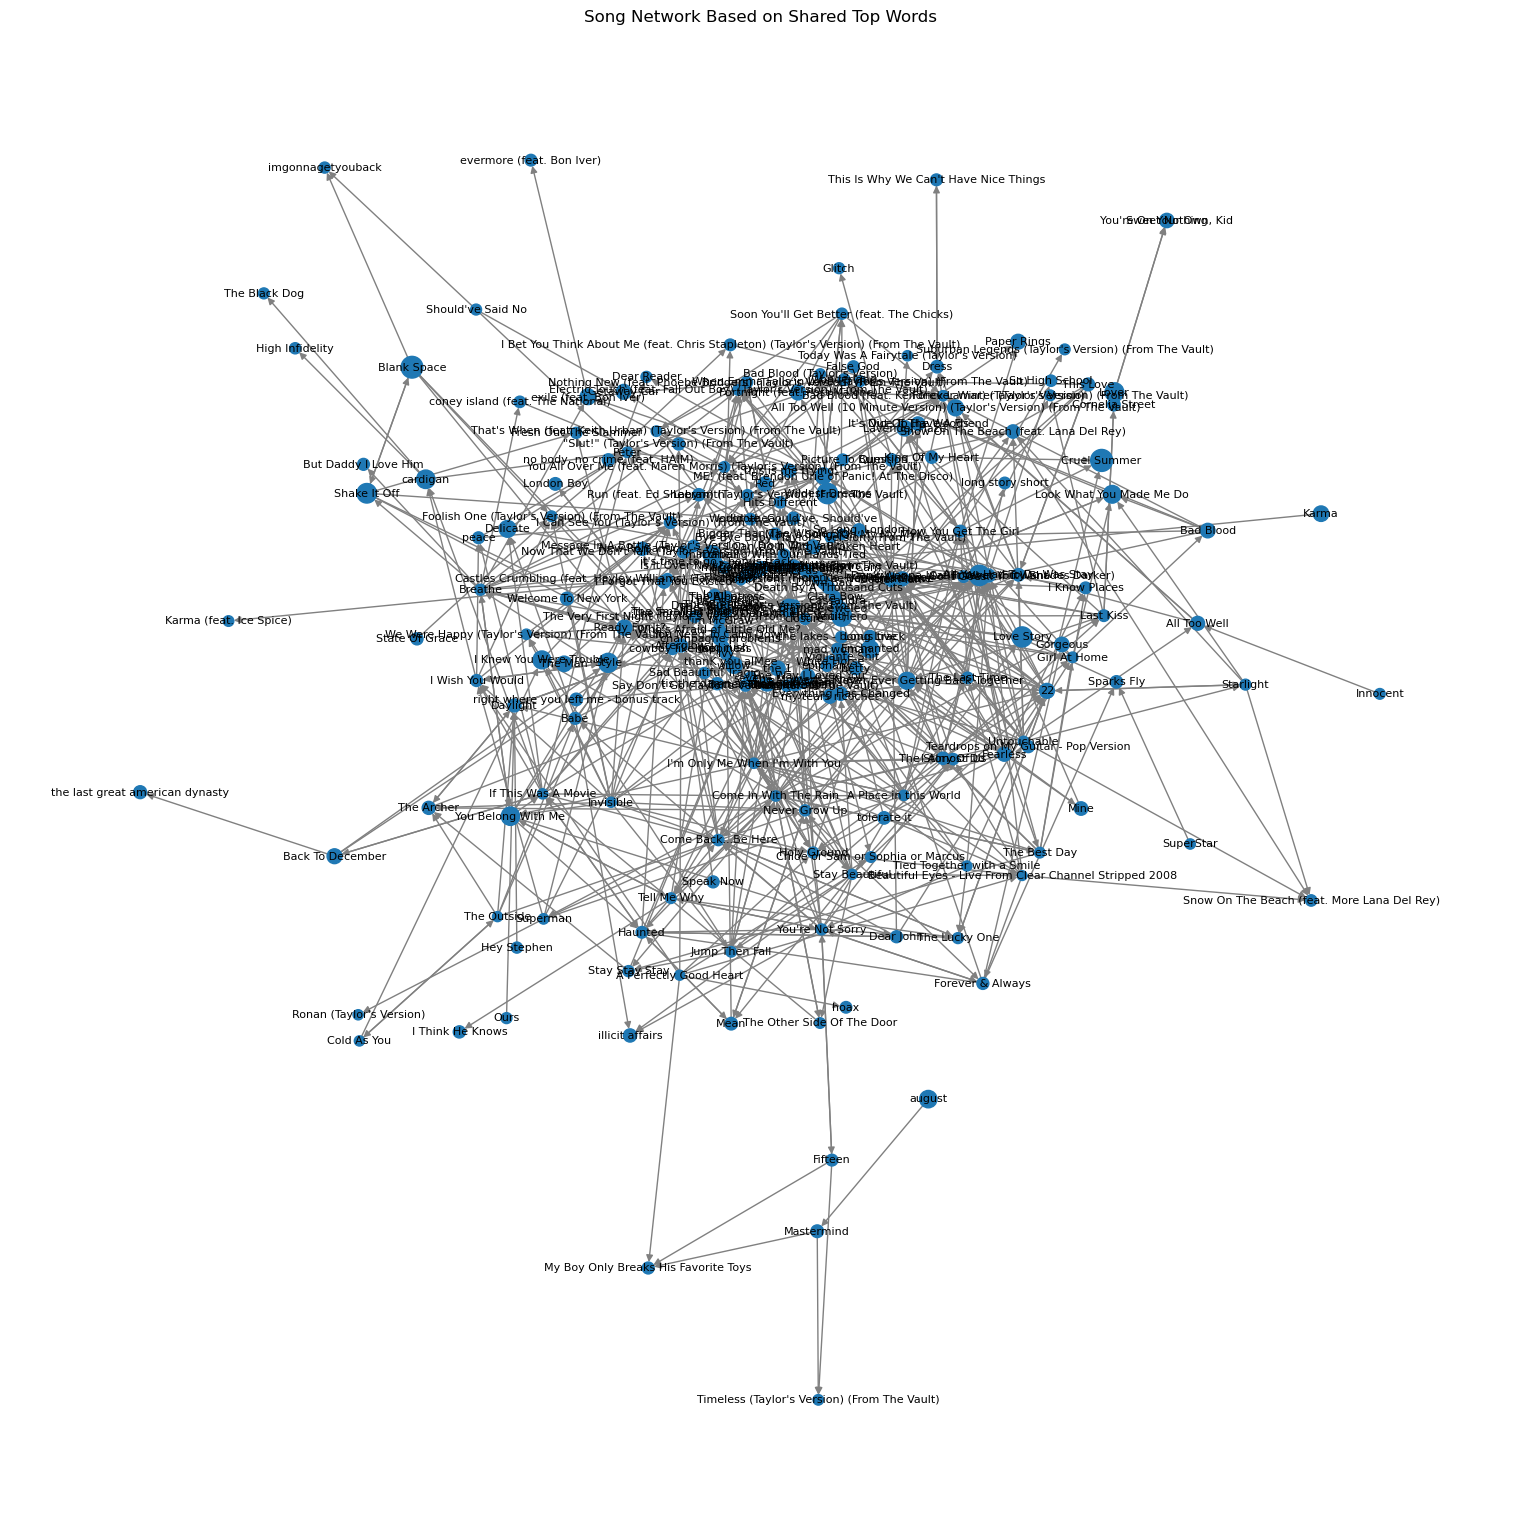

Number of nodes: 235
Number of edges: 574


In [23]:
import networkx as nx

def build_song_network(ts_data, top_words_df, min_shared_words=1):
    """
    Builds a directed song network based on shared top words and release dates.

    Parameters:
        ts_data (DataFrame): The original dataset with song metadata, including release dates.
        top_words_df (DataFrame): DataFrame containing track names and their top words.
        min_shared_words (int): Minimum number of shared words required to create an edge.

    Returns:
        nx.DiGraph: A directed network of songs.
    """
    G = nx.DiGraph()

    # Build a mapping of song to top words
    song_to_words = dict(zip(top_words_df['track_name'], top_words_df['top_words']))

    # Add nodes to the graph
    for _, row in ts_data.iterrows():
        G.add_node(
            row['track_name'], 
            release_date=row['release_date'],
            genre=row['track_musical_genre'], 
            spotify_streams=row['spotify_streams'],
            album = row['album']
        )

    # Add edges based on shared words and release dates
    for song1, words1 in song_to_words.items():
        for song2, words2 in song_to_words.items():
            if song1 != song2:
                # Find common words between the two songs
                common_words = set([w[0] for w in words1]).intersection([w[0] for w in words2])
                if len(common_words) >= min_shared_words:
                    # Determine the direction of the edge based on release date
                    date1 = ts_data.loc[ts_data['track_name'] == song1, 'release_date'].iloc[0]
                    date2 = ts_data.loc[ts_data['track_name'] == song2, 'release_date'].iloc[0]

                    # Handle lists in release_date
                    if isinstance(date1, list):
                        date1 = min(date1)
                    if isinstance(date2, list):
                        date2 = min(date2)

                    # Add edge based on release date comparison
                    if date1 < date2:
                        G.add_edge(song1, song2, weight=len(common_words))
                    else:
                        G.add_edge(song2, song1, weight=len(common_words))

    return G

# Build the song network
net = build_song_network(updated_ts_data, top_words_df, min_shared_words=3)

node_sizes = []
for node in net.nodes:
    streams = net.nodes[node]['spotify_streams']
    if isinstance(streams, list):
        # If spotify_streams is a list, sum the values
        node_sizes.append(sum(streams))
    else:
        # If it's a single value, just append it
        node_sizes.append(streams)

# Normalize the node sizes to make them visually appropriate
max_streams = max(node_sizes)
min_streams = min(node_sizes)
print(min_streams, max_streams)
normalized_sizes = [50 + (size - min_streams) / (max_streams - min_streams) * 200 for size in node_sizes]



plt.figure(figsize=(15, 15))
pos = nx.kamada_kawai_layout(net)
nx.draw(
    net, pos, with_labels=True, 
    node_size=normalized_sizes, font_size=8, edge_color="gray", arrowsize=10
)
plt.title("Song Network Based on Shared Top Words")
plt.show()

# Display network statistics
print(f"Number of nodes: {net.number_of_nodes()}")
print(f"Number of edges: {net.number_of_edges()}")


In [24]:
# Save the network 
with open('song_network.pkl', 'wb') as f:
    pickle.dump(net, f)

In [25]:
updated_ts_data.to_pickle("ts_data.pkl")
print("DataFrame saved as 'updated_ts_data.pkl'")

DataFrame saved as 'updated_ts_data.pkl'


In [26]:
# print(updated_ts_data['spotify_streams'].apply(type).value_counts())

In [27]:
# def normalize_streams(value):
#     if isinstance(value, list):
#         return sum(value)  # Sum the elements in the list
#     return int(value)  # Return the value as an integer

# # Apply the normalization function to the column
# updated_ts_data['spotify_streams'] = updated_ts_data['spotify_streams'].apply(normalize_streams)

# # Verify the column type again
# print(updated_ts_data['spotify_streams'].apply(type).value_counts())  # Should only show <class 'int'>
# print(updated_ts_data['spotify_streams'].dtype)  # Should show int64

In [28]:
# import pygraphviz as pgv
# import pandas as pd
# from datetime import datetime
# import matplotlib.pyplot as plt

# def build_song_network_pygraphviz(ts_data, top_words_df, min_shared_words=1):
#     """
#     Builds a directed song network using PyGraphviz based on shared top words and release dates.

#     Parameters:
#         ts_data (DataFrame): The original dataset with song metadata, including release dates.
#         top_words_df (DataFrame): DataFrame containing track names and their top words.
#         min_shared_words (int): Minimum number of shared words required to create an edge.

#     Returns:
#         pgv.AGraph: A directed network of songs.
#     """
#     G = pgv.AGraph(directed=True)

#     # Build a mapping of song to top words
#     song_to_words = dict(zip(top_words_df['track_name'], top_words_df['top_words']))

#     # Add nodes with attributes
#     for _, row in ts_data.iterrows():
#         G.add_node(
#             row['track_name'],
#             release_date=row['release_date'],  # Add release date as an attribute
#             spotify_streams=row['spotify_streams'],  # Add Spotify streams as an attribute
#             shape="ellipse",
#         )

#     # Add edges based on shared words and release dates
#     for song1, words1 in song_to_words.items():
#         for song2, words2 in song_to_words.items():
#             if song1 != song2:
#                 # Find common words between the two songs
#                 common_words = set([w[0] for w in words1]).intersection([w[0] for w in words2])
#                 if len(common_words) >= min_shared_words:
#                     # Determine the direction of the edge based on release date
#                     date1 = ts_data.loc[ts_data['track_name'] == song1, 'release_date'].iloc[0]
#                     date2 = ts_data.loc[ts_data['track_name'] == song2, 'release_date'].iloc[0]

#                     # Handle lists in release_date
#                     if isinstance(date1, list):
#                         date1 = min(date1)
#                     if isinstance(date2, list):
#                         date2 = min(date2)

#                     # Add edge based on release date comparison
#                     if date1 < date2:
#                         G.add_edge(song1, song2, label=f"{len(common_words)} words")
#                     else:
#                         G.add_edge(song2, song1, label=f"{len(common_words)} words")

#     return G

# # Build the song network using PyGraphviz
# net = build_song_network_pygraphviz(updated_ts_data, top_words_df, min_shared_words=3)

# # Compute node sizes based on Spotify streams
# node_sizes = []
# for node in net.nodes():
#     streams = net.get_node(node).attr['spotify_streams']
#     if isinstance(streams, list):
#         node_sizes.append(sum(streams))  # Sum if multiple streams are present
#     else:
#         node_sizes.append(int(streams))  # Convert single value to int if needed

# # Normalize node sizes for visualization
# max_streams = max(node_sizes)
# min_streams = min(node_sizes)
# normalized_sizes = [50 + (size - min_streams) / (max_streams - min_streams) * 200 for size in node_sizes]

# # Assign sizes to nodes
# for i, node in enumerate(net.nodes()):
#     net.get_node(node).attr['width'] = normalized_sizes[i] / 100 
#     net.get_node(node).attr['height'] = normalized_sizes[i] / 100

# # Set general graph attributes
# net.graph_attr['label'] = "Song Network Based on Shared Top Words"
# net.graph_attr['labelloc'] = "t"
# net.graph_attr['fontsize'] = 20

# # Save and visualize the graph
# net.layout(prog='sfdp')  # Choose a layout (dot, neato, etc.)
# output_file = "song_network.png"
# net.draw(output_file)

# # Display the graph in Jupyter
# img = plt.imread(output_file)
# plt.figure(figsize=(15, 15))
# plt.imshow(img)
# plt.axis('off')
# plt.show()

# # Display network statistics
# print(f"Number of nodes: {len(net.nodes())}")
# print(f"Number of edges: {len(net.edges())}")

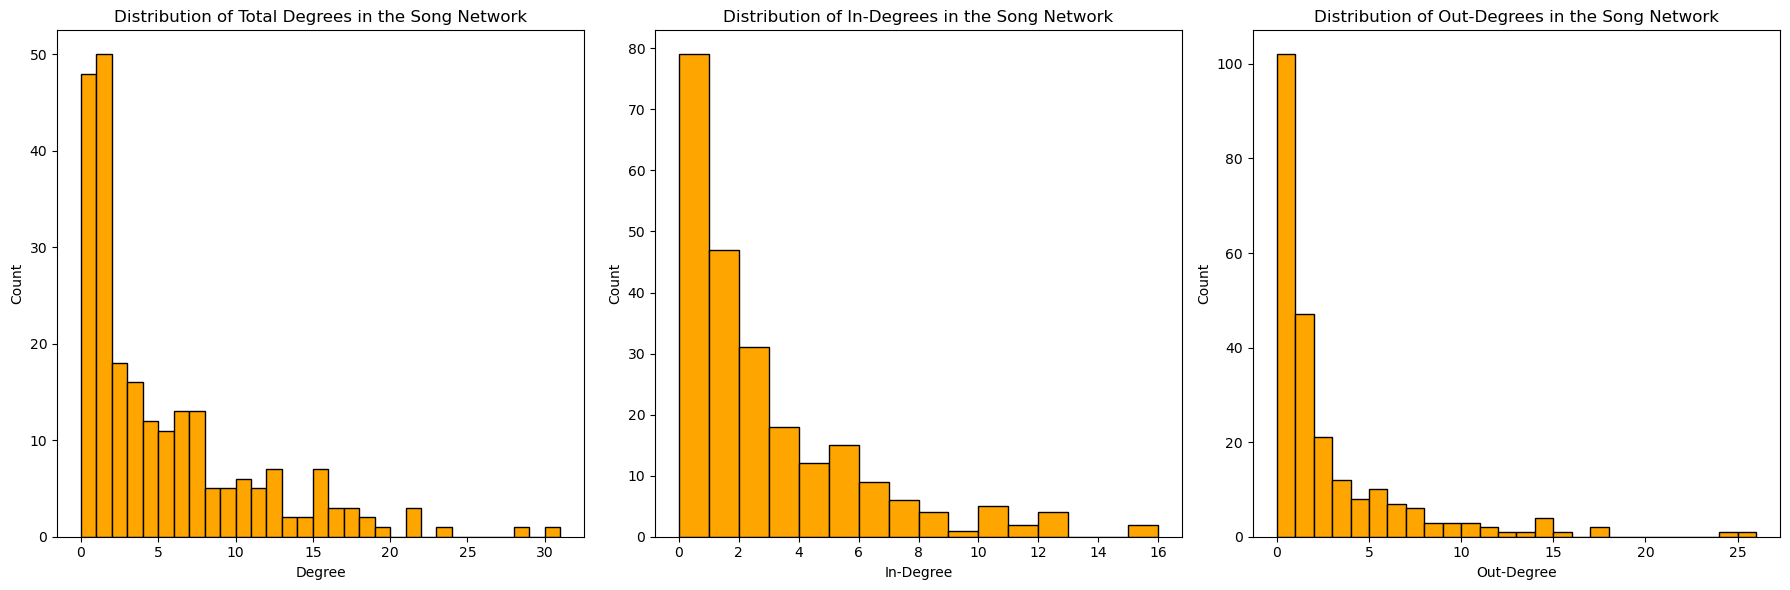

In [29]:
# Calculate degree, in-degree, and out-degree for each node
degrees = [d for n, d in net.degree()]
in_degrees = [d for n, d in net.in_degree()]
out_degrees = [d for n, d in net.out_degree()]

# Plot degree distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Total Degree Distribution
axes[0].hist(degrees, bins=range(0, max(degrees) + 1), color='orange', edgecolor='black')
axes[0].set_title('Distribution of Total Degrees in the Song Network')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Count')

# In-Degree Distribution
axes[1].hist(in_degrees, bins=range(0, max(in_degrees) + 1), color='orange', edgecolor='black')
axes[1].set_title('Distribution of In-Degrees in the Song Network')
axes[1].set_xlabel('In-Degree')
axes[1].set_ylabel('Count')

# Out-Degree Distribution
axes[2].hist(out_degrees, bins=range(0, max(out_degrees) + 1), color='orange', edgecolor='black')
axes[2].set_title('Distribution of Out-Degrees in the Song Network')
axes[2].set_xlabel('Out-Degree')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()



In [30]:
from tabulate import tabulate

# Find the top 5 songs with the highest in-degree
top_in_degree = sorted(net.in_degree(), key=lambda x: x[1], reverse=True)[:5]
in_degree_table = [[song, degree] for song, degree in top_in_degree]

# Find the top 5 songs with the highest out-degree
top_out_degree = sorted(net.out_degree(), key=lambda x: x[1], reverse=True)[:5]
out_degree_table = [[song, degree] for song, degree in top_out_degree]

# Print tables
print("Top 5 Songs with Highest In-Degree (Most Influenced):")
print(tabulate(in_degree_table, headers=["Song", "In-Degree"], tablefmt="grid"))

print("\nTop 5 Songs with Highest Out-Degree (Most Influential):")
print(tabulate(out_degree_table, headers=["Song", "Out-Degree"], tablefmt="grid"))


Top 5 Songs with Highest In-Degree (Most Influenced):
+-------------------------------------------------------------------------------+-------------+
| Song                                                                          |   In-Degree |
+===============================================================================+=============+
| Afterglow                                                                     |          16 |
+-------------------------------------------------------------------------------+-------------+
| Say Don't Go (Taylor's Version) (From The Vault)                              |          15 |
+-------------------------------------------------------------------------------+-------------+
| Bad Blood (feat. Kendrick Lamar) (Taylor's Version)                           |          12 |
+-------------------------------------------------------------------------------+-------------+
| Castles Crumbling (feat. Hayley Williams) (Taylor's Version) (From The Vault) | 

In [31]:
# centrality
#Communities